In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-manufacturing-defects-dataset/manufacturing_defect_dataset.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.core.display import display, HTML

## Reading the data 

In [3]:
df = pd.read_csv("/kaggle/input/predicting-manufacturing-defects-dataset/manufacturing_defect_dataset.csv")

In [4]:
df.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


In [5]:
df.describe()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
count,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000
mean,548.523148,12423.018476,89.833290,2.558951,2.749116,80.134272,11.476543,2.501373,6.019662,0.050878,90.040115,4.591667,2988.494453,0.299776,5.472098,299.515479,0.840432
std,262.402073,4308.051904,5.759143,1.705804,1.310154,11.611750,6.872684,1.443684,2.329791,0.028797,5.723600,2.896313,1153.420820,0.116400,2.598212,116.379905,0.366261
min,100.000000,5000.174521,80.004820,0.000000,0.500710,60.010098,0.000000,0.001665,2.001611,0.000002,80.004960,0.000000,1000.720156,0.100238,1.000151,100.211137,0.000000
25%,322.000000,8728.829280,84.869219,1.000000,1.598033,70.103420,5.750000,1.264597,3.983249,0.026200,85.180203,2.000000,1988.140273,0.200502,3.228507,194.922058,1.000000
50%,549.000000,12405.204656,89.704861,3.000000,2.708775,80.265312,12.000000,2.465151,6.022389,0.051837,90.125743,5.000000,2996.822301,0.297470,5.437134,299.728918,1.000000
75%,775.250000,16124.462428,94.789936,4.000000,3.904533,90.353822,17.000000,3.774861,8.050222,0.075473,95.050838,7.000000,3984.788299,0.402659,7.741006,403.178283,1.000000
max,999.000000,19993.365549,99.989214,5.000000,4.998529,99.996993,23.000000,4.997591,9.998577,0.099997,99.996786,9.000000,4997.074741,0.499500,9.999749,499.982782,1.000000


So there are total of 17 features with about 3240 rows each 

## Exploratory data analysis

In [6]:
# looking for null values - 

df.isna().sum()

ProductionVolume        0
ProductionCost          0
SupplierQuality         0
DeliveryDelay           0
DefectRate              0
QualityScore            0
MaintenanceHours        0
DowntimePercentage      0
InventoryTurnover       0
StockoutRate            0
WorkerProductivity      0
SafetyIncidents         0
EnergyConsumption       0
EnergyEfficiency        0
AdditiveProcessTime     0
AdditiveMaterialCost    0
DefectStatus            0
dtype: int64

No null values are there in the data 

## Count of labels and there Ratio


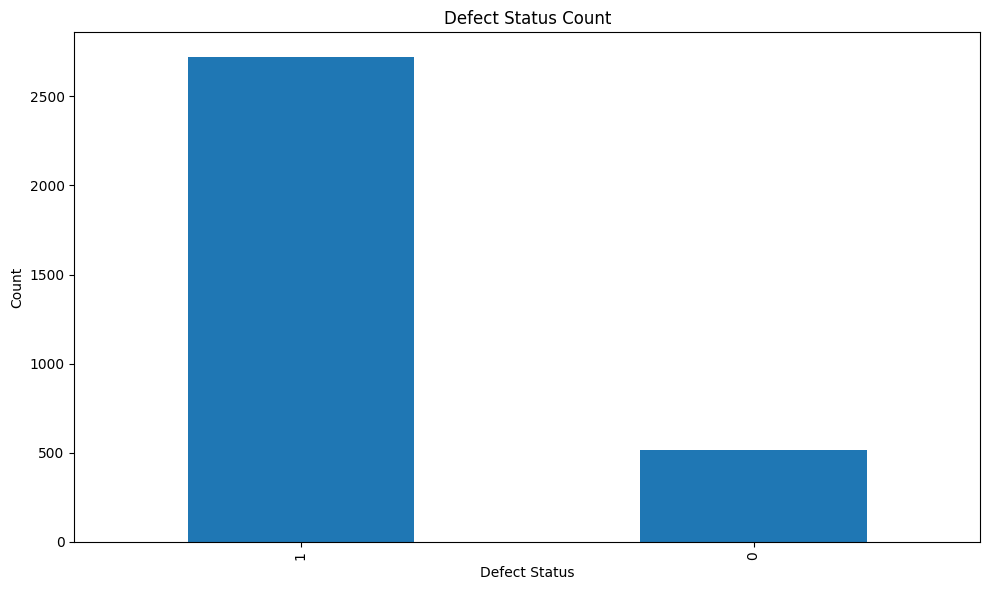

In [7]:

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed
count = df["DefectStatus"].value_counts()
count.plot(kind="bar", ax=ax)

# Adding labels for clarity
ax.set_title("Defect Status Count")
ax.set_xlabel("Defect Status")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


The data is highly imbalanced

## Correlation Matrix for all the features 

In [8]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
ProductionVolume,1.000000,0.029584,-0.026559,0.016193,-0.019360,0.017826,-0.004554,0.019905,0.006947,-0.002637,0.004754,-0.024195,-0.010213,0.009923,-0.042393,-0.002980,0.128973
ProductionCost,0.029584,1.000000,-0.024103,0.017365,0.014428,-0.001603,0.007333,-0.004078,0.022749,0.006006,0.005030,-0.006958,-0.006728,-0.002778,0.011075,-0.002114,0.026720
SupplierQuality,-0.026559,-0.024103,1.000000,0.014233,0.012157,-0.029330,-0.019626,0.006298,0.018228,-0.001393,-0.017389,0.004552,-0.003582,-0.011614,-0.012507,-0.002430,0.038184
DeliveryDelay,0.016193,0.017365,0.014233,1.000000,-0.023024,0.017268,0.018144,0.046247,0.006685,-0.002767,-0.013869,0.006030,0.007233,0.029468,0.028085,-0.007601,0.005425
DefectRate,-0.019360,0.014428,0.012157,-0.023024,1.000000,-0.036350,-0.008687,-0.011208,-0.014148,0.007547,-0.000388,0.012196,0.005297,-0.014168,-0.028426,0.011596,0.245746
QualityScore,0.017826,-0.001603,-0.029330,0.017268,-0.036350,1.000000,-0.013366,-0.000505,-0.000618,-0.035049,0.004591,0.001293,-0.001694,-0.004147,0.009986,-0.021223,-0.199219
MaintenanceHours,-0.004554,0.007333,-0.019626,0.018144,-0.008687,-0.013366,1.000000,-0.020494,0.012758,0.019251,0.009622,0.009174,0.007017,-0.026486,-0.001820,-0.000845,0.297107
DowntimePercentage,0.019905,-0.004078,0.006298,0.046247,-0.011208,-0.000505,-0.020494,1.000000,0.010176,0.001578,-0.037814,0.003673,0.003447,0.012885,-0.008031,0.002355,0.004128
InventoryTurnover,0.006947,0.022749,0.018228,0.006685,-0.014148,-0.000618,0.012758,0.010176,1.000000,0.026002,0.001469,-0.017555,0.026336,0.025029,0.019967,0.000176,0.006733
StockoutRate,-0.002637,0.006006,-0.001393,-0.002767,0.007547,-0.035049,0.019251,0.001578,0.026002,1.000000,-0.035034,0.031724,-0.000690,0.025852,0.000870,-0.020563,0.040574


Analysis of the correlation matrix tells that there is no redundant features that we need to edit

## Average values per each numerical feature among malfunctioned and non-malfunctiones machines

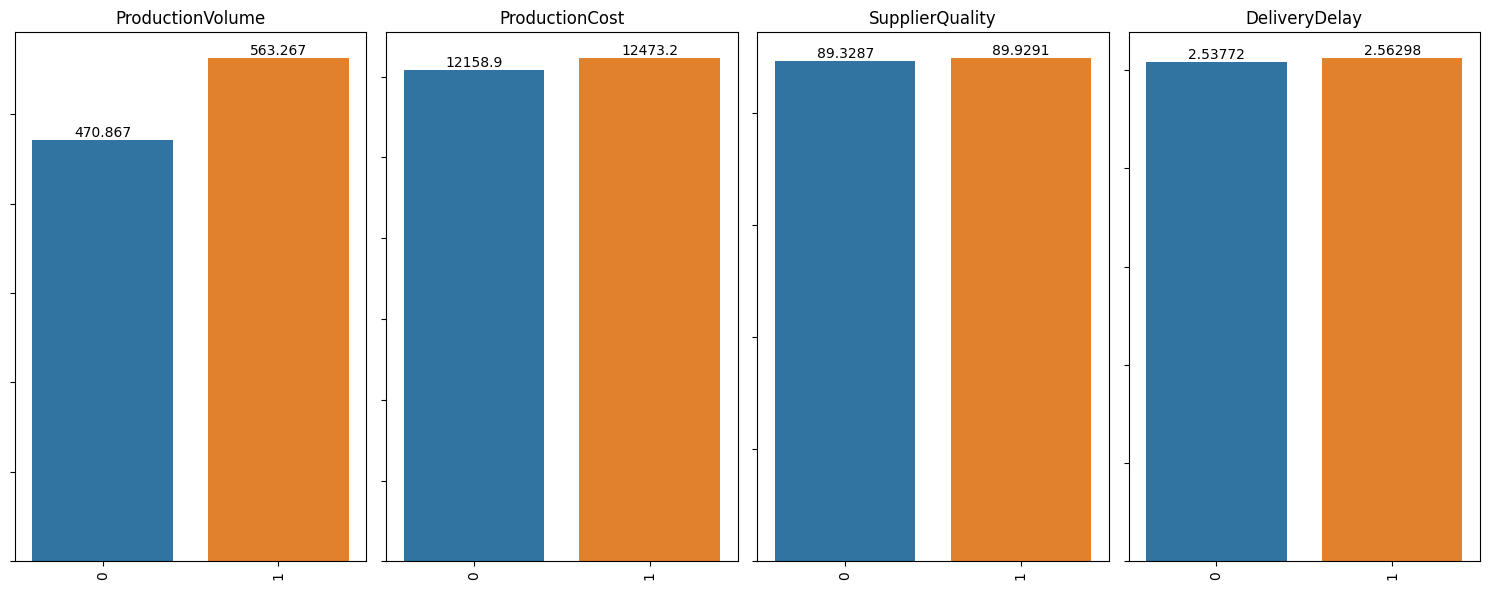

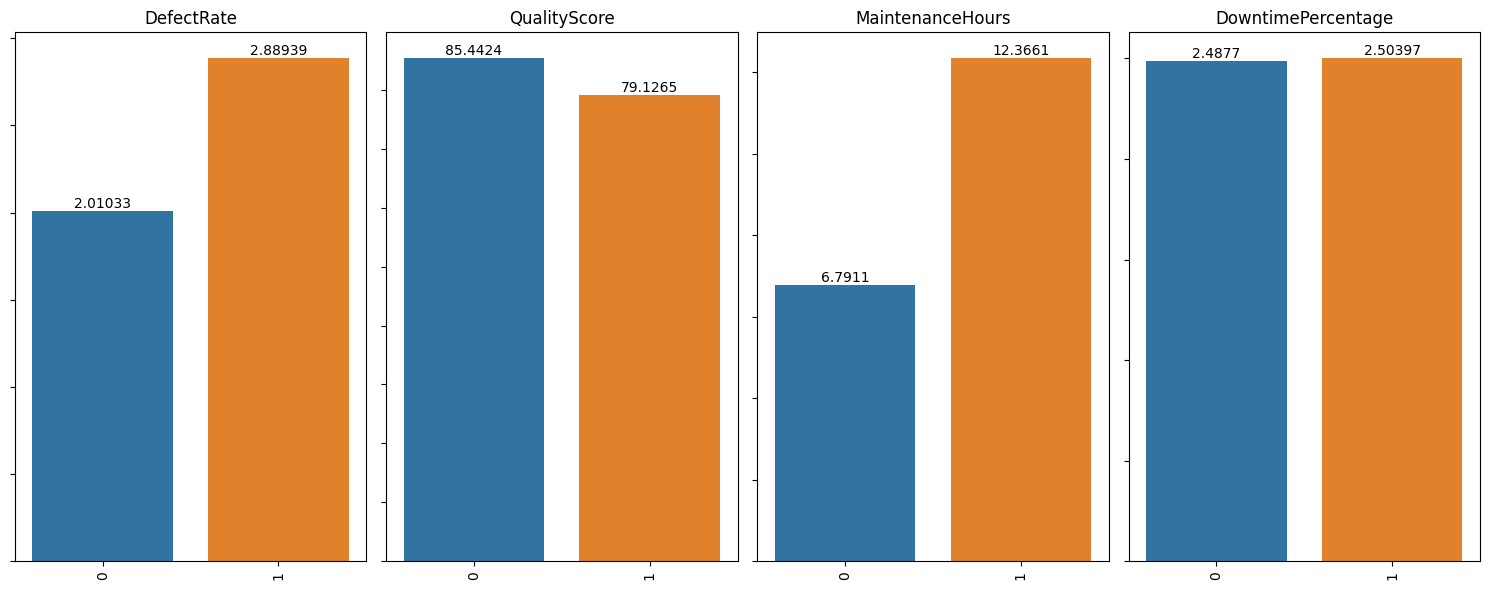

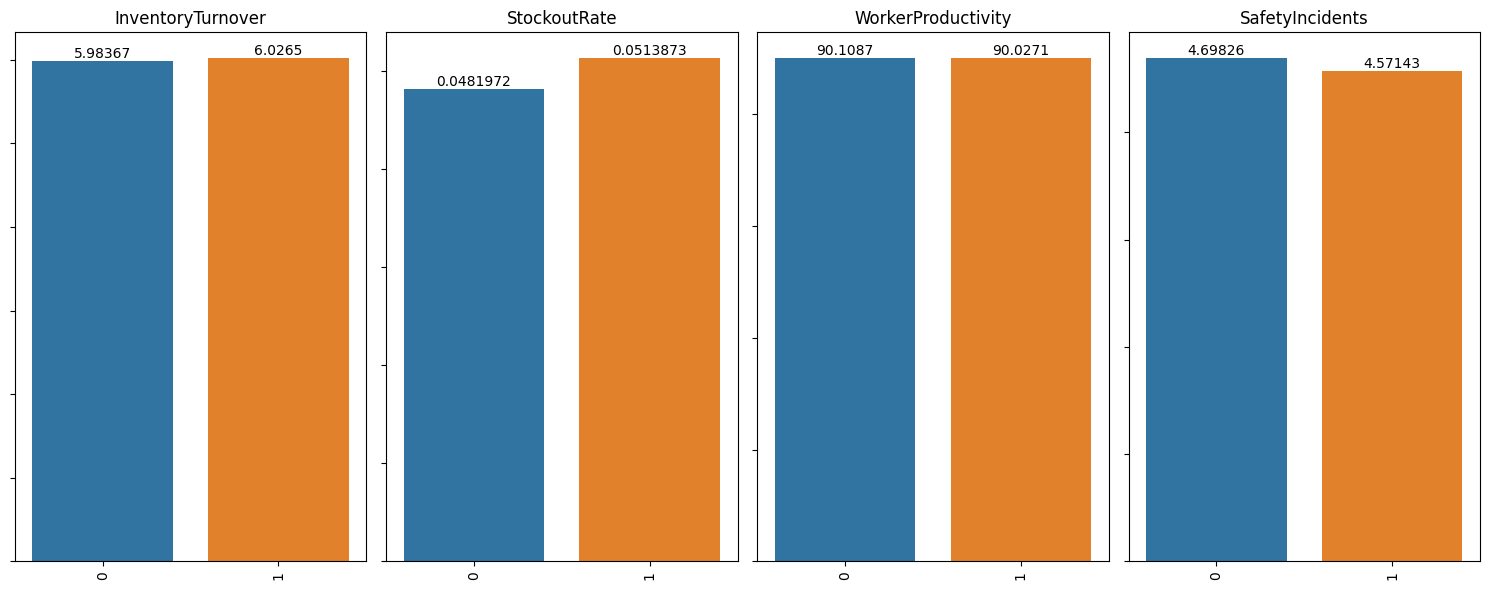

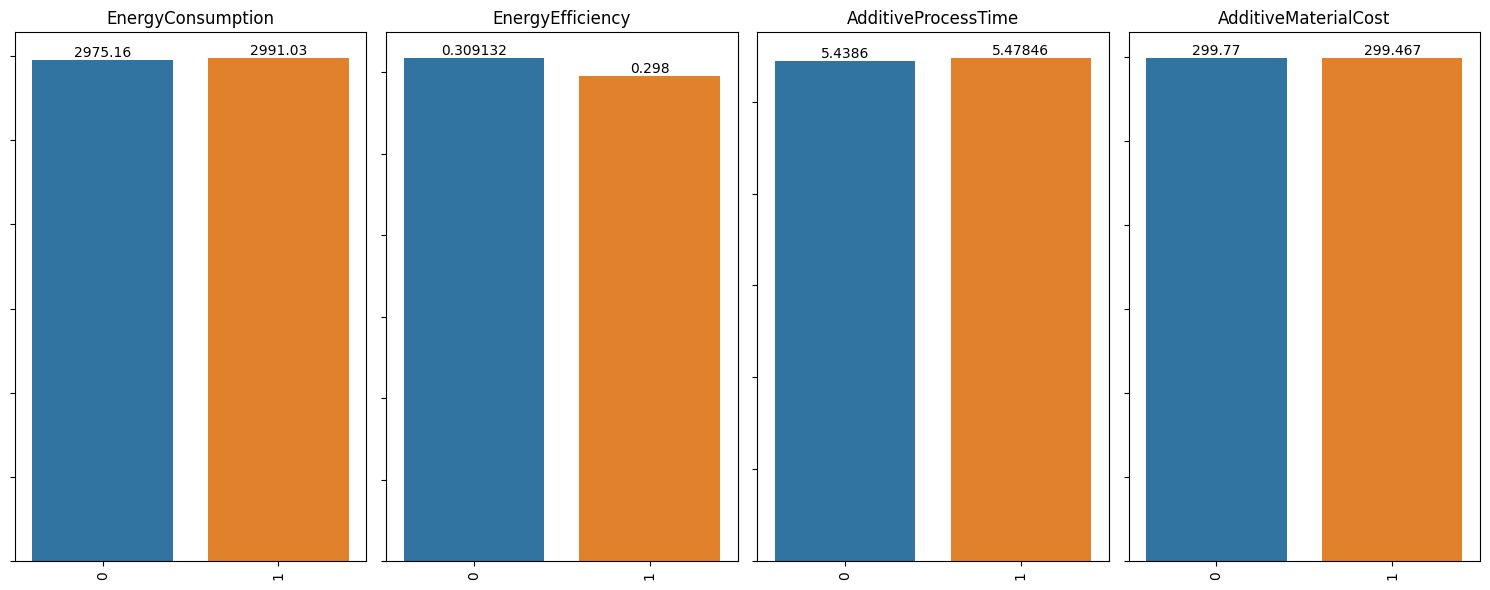

In [9]:
grouped = df.groupby("DefectStatus")
nums = df.columns[:-1].tolist()

index = 0

for i in range(4):
    fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
    for j in range(4):
        mean = grouped[nums[index]].mean()
        sns.barplot(x=mean.index, y=mean, ax=axes[j])
        for container in axes[j].containers:
            axes[j].bar_label(container)
        axes[j].set_yticklabels(())
        axes[j].set_xticklabels(axes[j].get_xticklabels(), rotation=90)
        axes[j].set_ylabel("")
        axes[j].set_xlabel("")
        axes[j].set_title(nums[index])
        index += 1
    plt.tight_layout()
    plt.show()

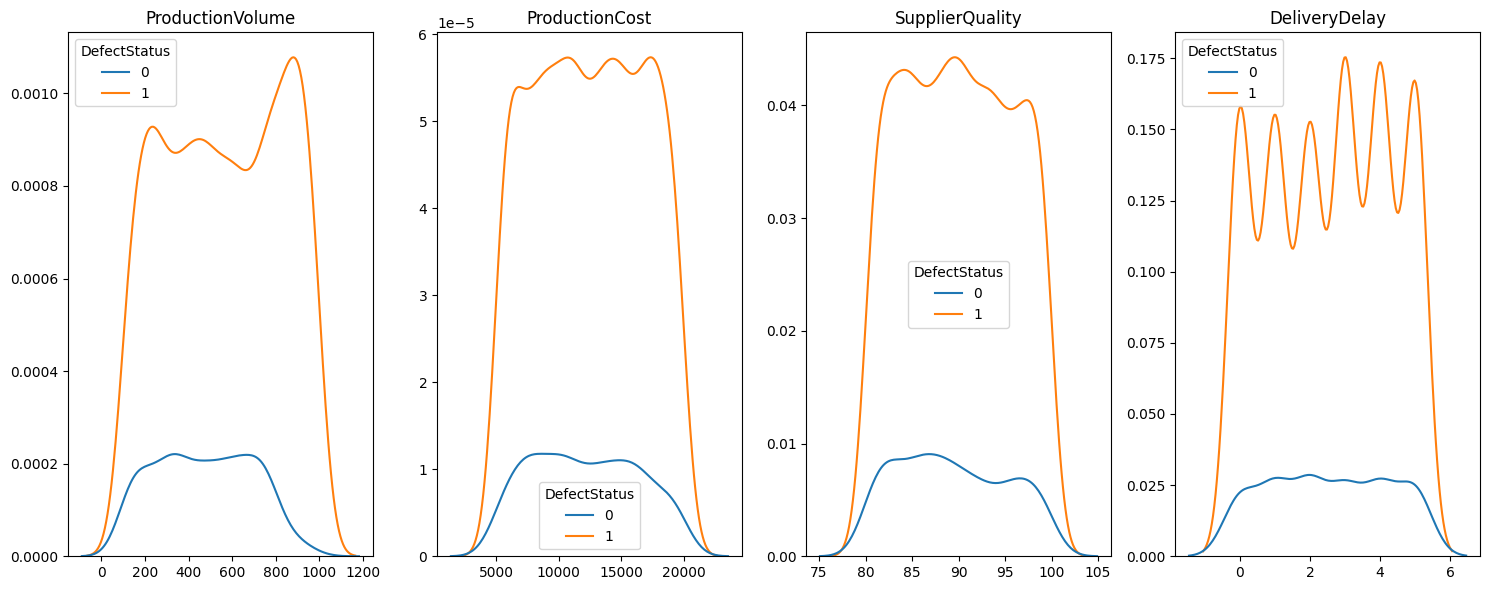

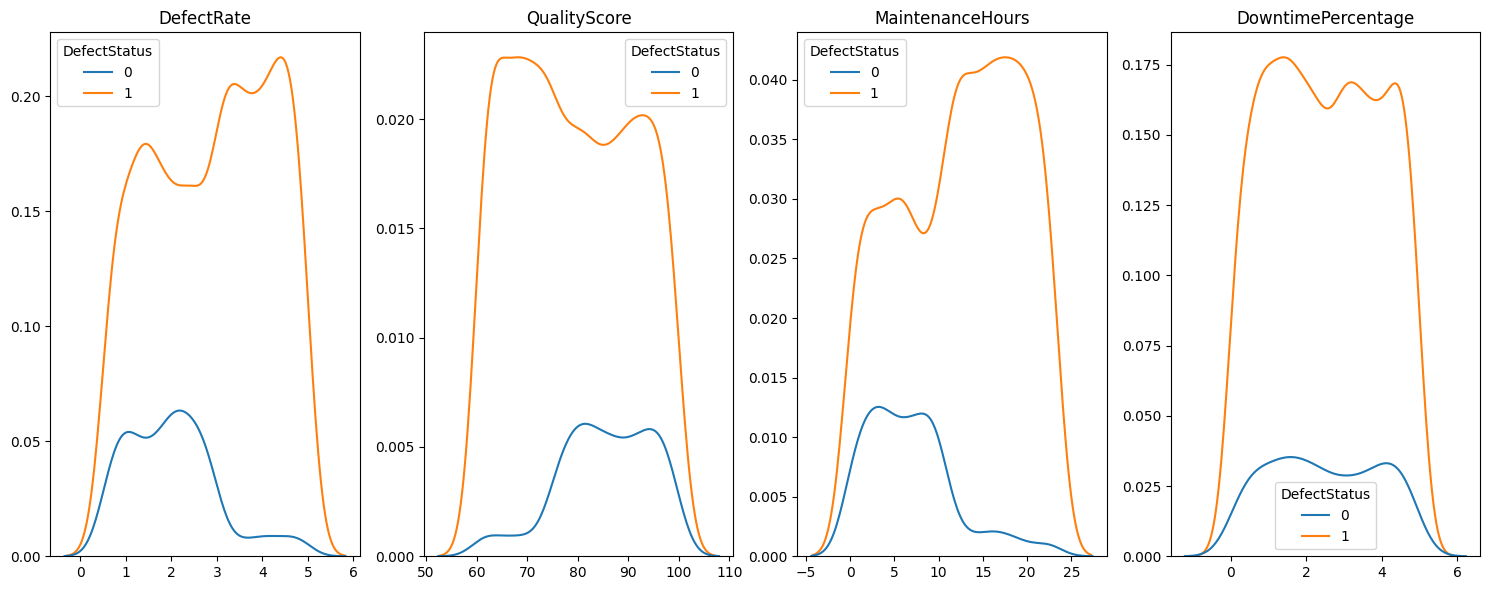

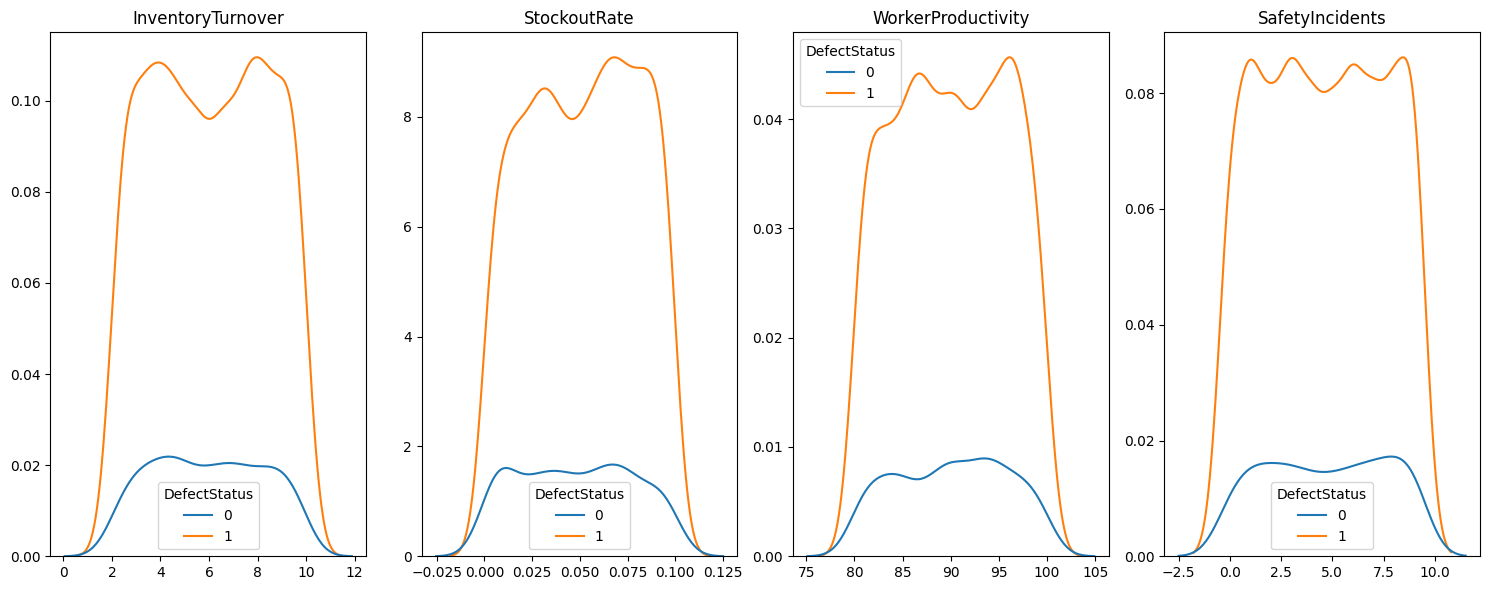

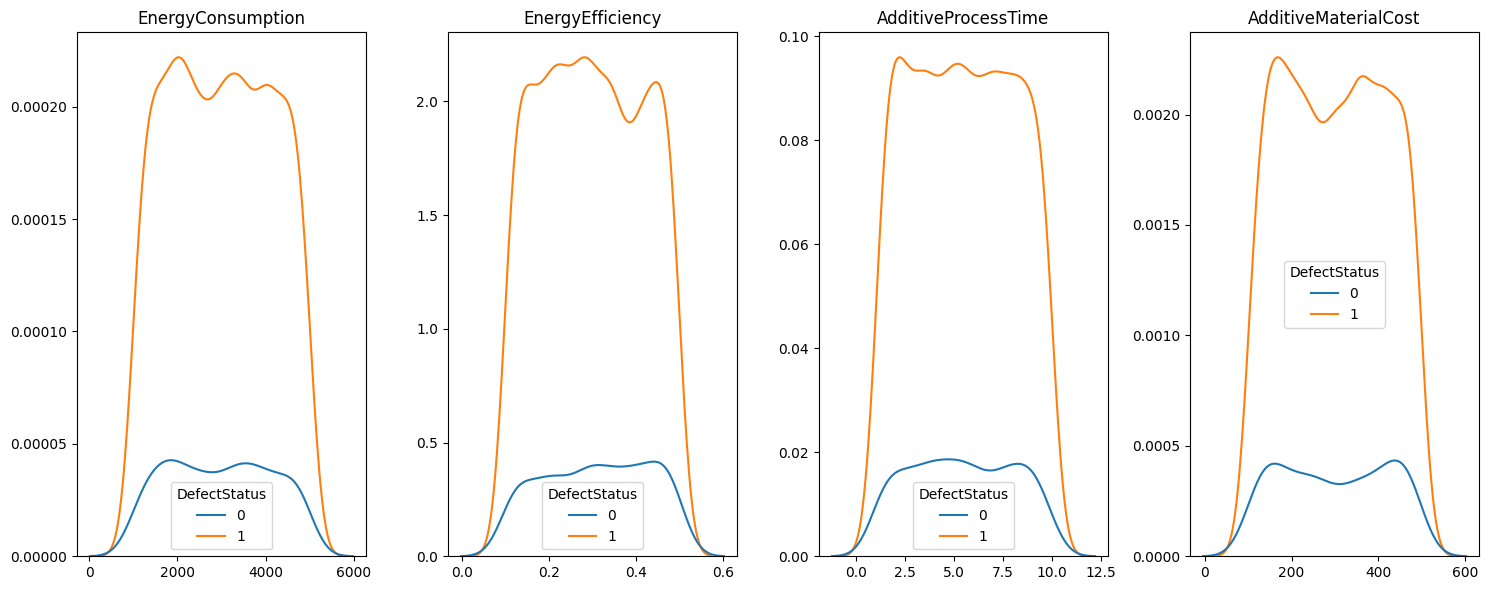

In [10]:

index = 0

for i in range(4):
    fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
    for j in range(4):
        sns.kdeplot(df, x=nums[index], hue=df.columns[-1], ax=axes[j])
        axes[j].set_ylabel("")
        axes[j].set_xlabel("")
        axes[j].set_title(nums[index])
        index += 1
    plt.tight_layout()
    plt.show()

## Scaling the data 

In [11]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

scaler = MinMaxScaler()

x = scaler.fit_transform(x)

## Spliting into train and test

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

## Synthetic Minority Over-sampling Techniquabse

In [13]:
from collections import Counter

print("Before: ", Counter(y_train))

smote = SMOTE()

x_train, y_train = smote.fit_resample(x_train, y_train)

print("After: ", Counter(y_train))

Before:  Counter({1: 2177, 0: 415})
After:  Counter({1: 2177, 0: 2177})


## Getting the feature importance from random forest classifiers

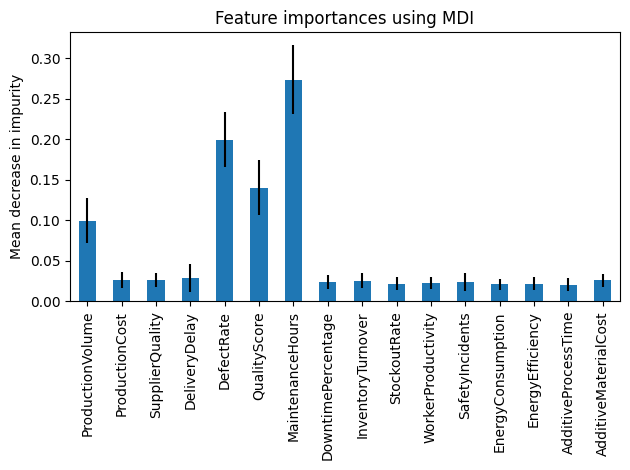

In [14]:
forest = RandomForestClassifier()

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


forest_importances = pd.Series(importances, index=df.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
def training(model):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    score = accuracy_score(pred, y_test)
    report = classification_report(pred, y_test)
    cm = confusion_matrix(pred, y_test)
    
    return score*100, report, cm


## Testing different machine learning models for the data 

In [16]:
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
lgr = LogisticRegression()
svc = SVC()
xgb = XGBClassifier()
lgb = LGBMClassifier()

models = [rfc, abc, gbc,
         lgr, svc, xgb, lgb]

names = ["Random Forest", "Ada Boost", "Gradient Boosting",
        "Logistic Regression", "Support Vector Machine", "XGBoost", "LightGBM"]

In [17]:
scores, reports, cms = [], dict(), dict()

for i, j in zip(models, names):
    score, report, cm = training(i)
    scores += [score]
    reports[j] = report
    cms[j] = cm

[LightGBM] [Info] Number of positive: 2177, number of negative: 2177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 4354, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


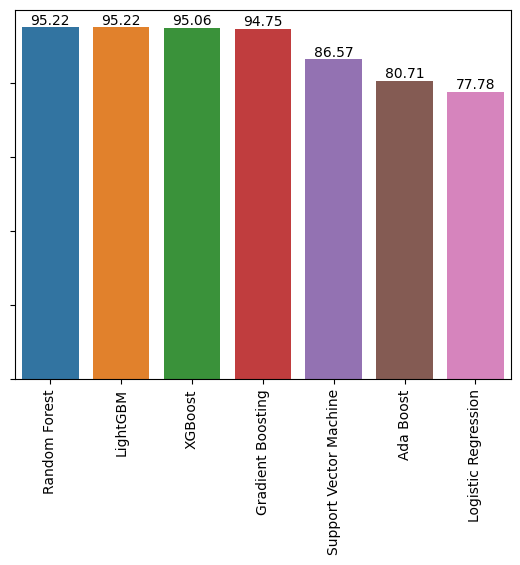

In [18]:
dd = pd.DataFrame({"scores": scores}, index=names)
dd = dd.sort_values("scores", ascending=False)
dd["scores"] = round(dd["scores"], 2)

fig, axes = plt.subplots()

sns.barplot(x=dd.index, y=dd.iloc[:, 0], ax=axes)
for container in axes.containers:
    axes.bar_label(container)
axes.set_yticklabels(())
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set_ylabel("")
axes.set_xlabel("")
plt.show()

## acc to this random forest works best

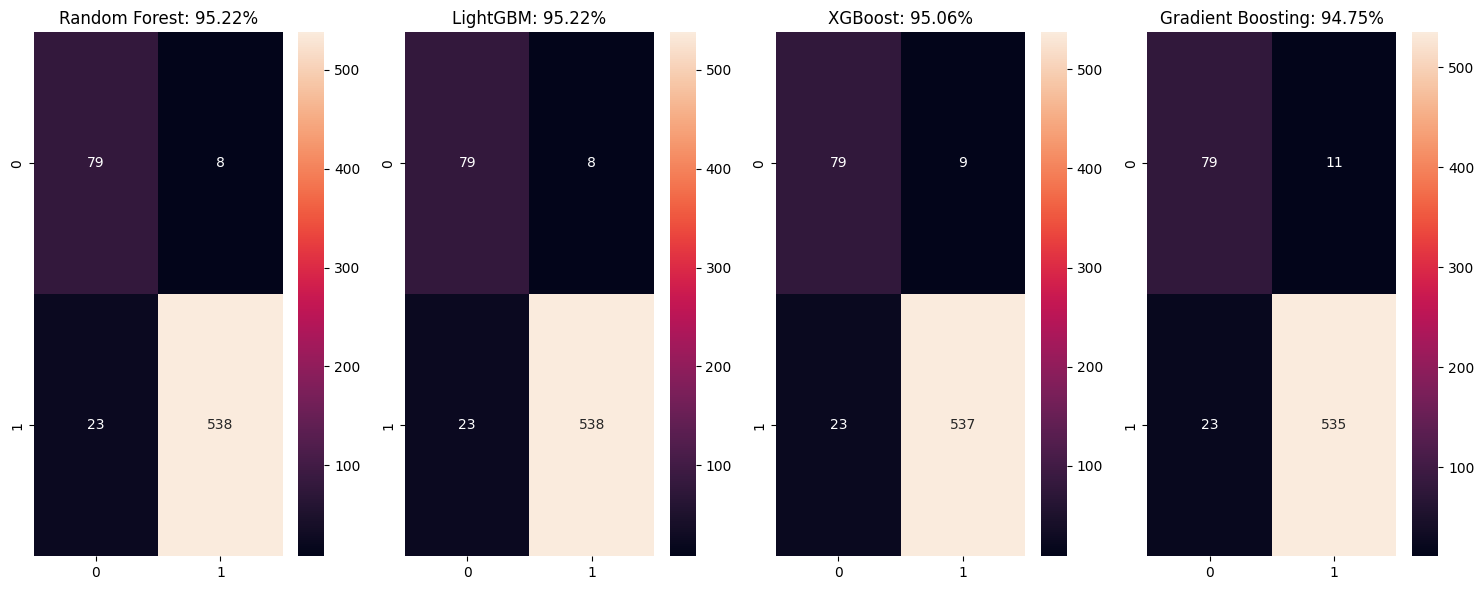

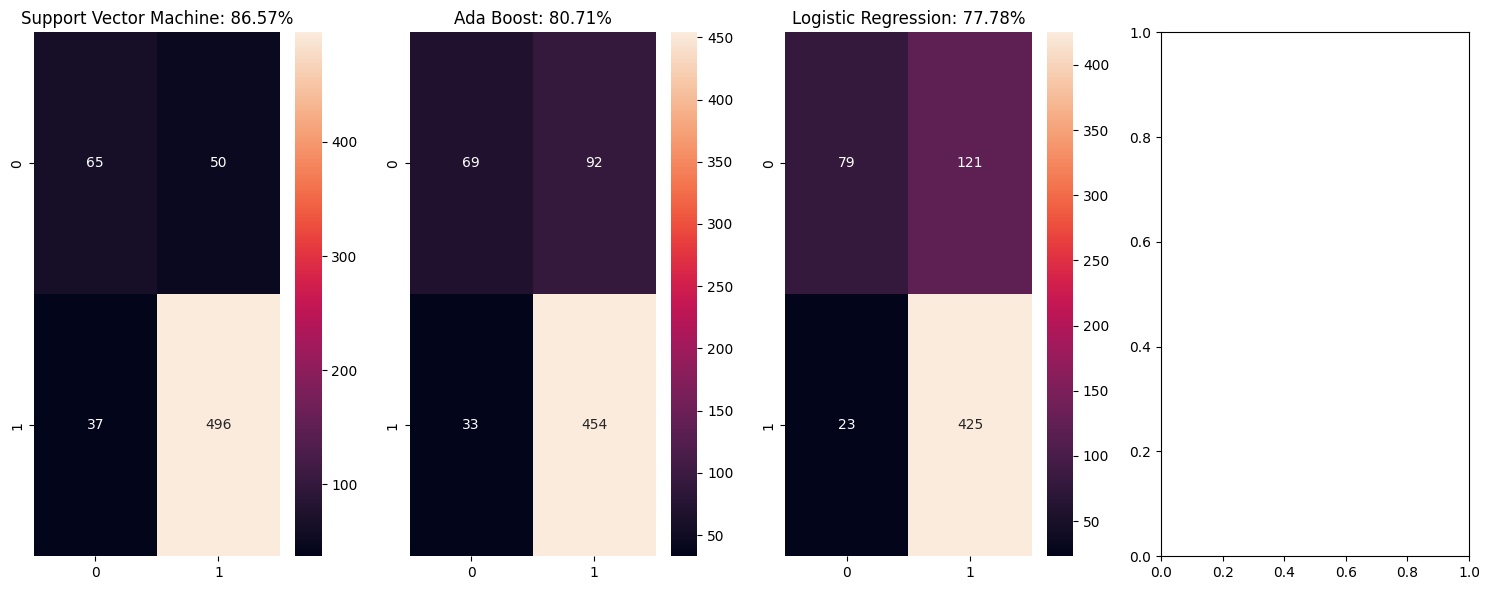

In [23]:
index = 0

for i in range(2):
    fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
    
    for j in range(4):
        if(index == 7):
            break;
        sns.heatmap(cms[dd.index[index]], ax=axes[j], annot=True, fmt='d')
        axes[j].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
        
        index += 1
    plt.tight_layout()
    plt.show()

In [24]:
for i in dd.index:
    print("*"*30)
    print(i)
    print(reports[i])
    print("\n\n")

******************************
Random Forest
              precision    recall  f1-score   support

           0       0.77      0.91      0.84        87
           1       0.99      0.96      0.97       561

    accuracy                           0.95       648
   macro avg       0.88      0.93      0.90       648
weighted avg       0.96      0.95      0.95       648




******************************
LightGBM
              precision    recall  f1-score   support

           0       0.77      0.91      0.84        87
           1       0.99      0.96      0.97       561

    accuracy                           0.95       648
   macro avg       0.88      0.93      0.90       648
weighted avg       0.96      0.95      0.95       648




******************************
XGBoost
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        88
           1       0.98      0.96      0.97       560

    accuracy                           0.95       64